In [2]:
import os
import torch
import numpy as np
from PIL import Image
from transformers import AutoModel
from transformers import AutoVideoProcessor
import sklearn as sk
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
hf_model_name = (
    "facebook/vjepa2-vitl-fpc64-256"  # Replace with your favored model, e.g. facebook/vjepa2-vitg-fpc64-384
)

# initialize model weights from huggingface
model_hf = AutoModel.from_pretrained(hf_model_name)
model_hf.to("mps", dtype = torch.float32).eval() 

# load model weights
hf_transform = AutoVideoProcessor.from_pretrained(hf_model_name)

In [4]:
# creating scenes for testing encoder

data_dir = 'data'
videos = []
# ensure deterministic scene order
scene_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

for folder in scene_names:
    folder_path = os.path.join(data_dir, folder)
    frames = []
    # ensure deterministic frame order within each scene
    for file in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, file)
        img = Image.open(img_path).convert("RGB")
        frames.append(np.array(img))

    video = np.stack(frames, axis=0)  # (T, H, W, 3)
    videos.append(video)
    print(f"{folder}: video shape {video.shape}")


scene1: video shape (16, 900, 1600, 3)
scene2: video shape (16, 900, 1600, 3)
scene3: video shape (16, 900, 1600, 3)
scene4: video shape (16, 900, 1600, 3)
scene5: video shape (16, 900, 1600, 3)
scene6: video shape (16, 900, 1600, 3)


In [5]:
# check model encoder

embeddings = []

for video in videos:
    inputs = hf_transform(video, return_tensors = 'pt')
    inputs = {k: v.to(model_hf.device) for k, v, in inputs.items()}

    with torch.no_grad():
        feats = model_hf.get_vision_features(**inputs)
        print("feats shape ", feats.shape)
        clip_emb = feats.mean(dim=1).squeeze(0).cpu().numpy() # global average pooling for downstream
        print("clim emb shape ", clip_emb.shape)
        embeddings.append(clip_emb)  


clip_embds = np.stack(embeddings, axis = 0) # tensor of all our embeddings

feats shape  torch.Size([1, 2048, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 2048, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 2048, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 2048, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 2048, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 2048, 1024])
clim emb shape  (1024,)


In [40]:
# L2 normalization of embeddings
clip_embds_norm = clip_embds / np.linalg.norm(clip_embds, axis = 1, keepdims = True)

# verifying changes
print(np.linalg.norm(clip_embds_norm, axis = 1))

[0.99999994 1.         1.         1.         1.         0.99999994]


In [42]:
# PCA on these tensors
pca_3 = sk.decomposition.PCA(n_components = 3) # 3 dimensinos
pca_2 = sk.decomposition.PCA(n_components = 2) # 2 dims
emb_3d = pca_3.fit_transform(clip_embds_norm)
emb_2d = pca_2.fit_transform(clip_embds_norm)



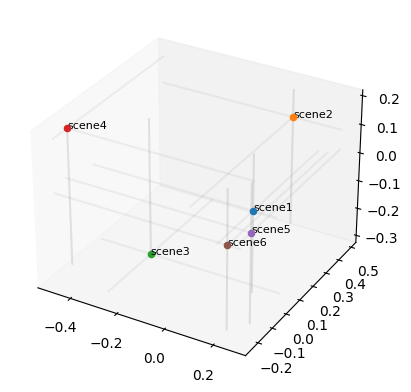

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, (x, y, z) in enumerate(emb_3d):
    ax.scatter(x, y, z)
    ax.text(x, y, z, scene_names[i] if 'scene_names' in globals() else f"scene_{i+1}", fontsize=8)

ax.grid(True)

# Lighten grid lines
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis._axinfo["grid"]["linewidth"] = 0.0


for (x, y, z) in emb_3d:
    ax.plot([x, x], [y, y], [min(emb_3d[:,2]), max(emb_3d[:,2])], color='gray', alpha=0.2)  # vertical lines
    ax.plot([x, x], [min(emb_3d[:,1]), max(emb_3d[:,1])], [z, z], color='gray', alpha=0.1)  # YZ plane hints
    ax.plot([min(emb_3d[:,0]), max(emb_3d[:,0])], [y, y], [z, z], color='gray', alpha=0.1)  # XZ plane hints


plt.show()

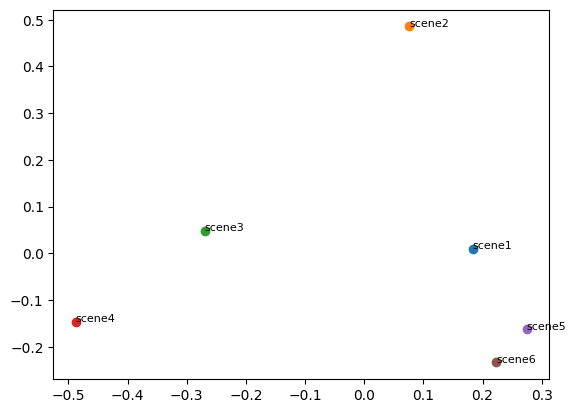

In [44]:
plt.figure()

for i, (x, y) in enumerate(emb_2d):
    plt.scatter(x, y)
    plt.text(x, y, scene_names[i] if 'scene_names' in globals() else f"scene_{i+1}", fontsize = 8)

plt.show()

In [45]:
# compute similarities

sims = sk.metrics.pairwise.cosine_similarity(clip_embds_norm)
print(np.round(sims, 3))

[[1.    0.851 0.835 0.729 0.927 0.937]
 [0.851 1.    0.77  0.636 0.749 0.716]
 [0.835 0.77  1.    0.843 0.766 0.782]
 [0.729 0.636 0.843 1.    0.678 0.712]
 [0.927 0.749 0.766 0.678 1.    0.941]
 [0.937 0.716 0.782 0.712 0.941 1.   ]]
